# Rt Live Model

Based on [Rt.live](https://Rt.live) model, original source code on [Github](https://github.com/rtcovidlive/covid-model).

Adapted for South Africa - Schalk van Heerden 12 July 2020 - Review required

In [1]:
%load_ext autoreload
%autoreload 2

from pip._internal import main
try:
    import pymc3 as pm
except:
    from pip._internal import main
    main(['install', 'pymc3'])
    import pymc3 as pm
        
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Setup
TODO: Complete GitHub automation. Progress: can install all libaries with conda, but issue running this complex notebook remotely. Move to a flat python file next.

Change paramter to **False** when running on your own local machine, but do not commit this change! Leave as **True** for Github Action `rtlive_model_action.yaml` to run remotely.

In [28]:
remote_run = False

## Troubleshooting

1. Ensure that all modules are installed with `conda` from `requirments.txt`
1. How to solve Theano library warnings on some OS platforms: [SO](https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano)

# Baseline model with US data

While testing, run US model first to baseline the latest model files. Remote run is not required. For the latest stable model, checkout commit from 2 July 2020.

## Fetch data and select the state's data

In [3]:
if not remote_run:
    df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [4]:
if not remote_run:
    region = "OR"
    model_data = df.loc[region]
    model_data.tail()

## Create the model instance and sample

In [5]:
if not remote_run:
    gm = GenerativeModel(region, model_data)
    gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [09:51<00:00,  6.08draws/s]


## Summarize Model Output

In [11]:
if not remote_run:
    result.tail(10)
    #result.tail(10)

100%|██████████| 800/800 [00:01<00:00, 433.31it/s]


## Plot Model Output

In [5]:
def plot_results():
    fig, ax = plt.subplots(figsize=(10,5))
    result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
    result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
    result.infections.plot(c="b", label="Infections")
    gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
    fig.set_facecolor('w')
    ax.legend();
 
if not remote_run:
    plot_results()

In [6]:
def plot_rt():
    fig, ax = plt.subplots(figsize=(10,5))

    ax.set_title(f"{region} $R_t$")
    samples = gm.trace['r_t']
    x=result.index
    cmap = plt.get_cmap("Reds")
    percs = np.linspace(51, 99, 40)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    samples = samples.T

    result["median"].plot(c="k", ls='-')

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

    ax.axhline(1.0, c="k", lw=1, linestyle="--")
    fig.set_facecolor('w')
 
if not remote_run:
    plot_rt()

# South African Results

In [7]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_cases = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_cases.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-07,20200707,40401.0,3034.0,71488.0,16743.0,1950.0,2353.0,888.0,6842.0,72156.0,0.0,215855,https://twitter.com/nicd_sa/status/12806201056...
2020-07-08,20200708,42357.0,3259.0,75015.0,17962.0,2131.0,2528.0,974.0,7147.0,73292.0,0.0,224665,https://twitter.com/nicd_sa/status/12809881629...
2020-07-09,20200709,44432.0,3724.0,81546.0,19630.0,2381.0,2902.0,1039.0,7870.0,74815.0,0.0,238339,https://twitter.com/DrZweliMkhize/status/12813...
2020-07-10,20200710,46284.0,4221.0,87033.0,21386.0,2579.0,3273.0,1168.0,8676.0,76067.0,0.0,250687,https://twitter.com/nicd_sa/status/12816671095...
2020-07-11,20200711,48232.0,4679.0,93044.0,23753.0,2835.0,3621.0,1266.0,9418.0,77336.0,0.0,264184,https://twitter.com/nicd_sa/status/12820534758...


In [8]:
#url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_testing.csv'
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-07,20200707,1907532.0,102299,NaN,NaN,NaN,3502,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/07/update-...
2020-07-08,20200708,1944399.0,106842,NaN,NaN,NaN,3602,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/08/update-...
2020-07-09,20200709,2000569.0,113061,NaN,NaN,NaN,3720,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/09/update-...
2020-07-10,20200710,2057232.0,118232,NaN,NaN,NaN,3860,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/10/update-...
2020-07-11,20200711,2108570.0,127715,NaN,NaN,NaN,3971,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/11/update-...


In [9]:
cases = pd.Series(states_cases['total'], index=states_cases.index, name='cases')
cases

date
2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-07    215855
2020-07-08    224665
2020-07-09    238339
2020-07-10    250687
2020-07-11    264184
Name: cases, Length: 127, dtype: int64

In [10]:
casezero = states_cases.index[0]
caselast = states_cases.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-11 00:00:00'))

In [11]:
idx = pd.date_range(casezero, caselast)

In [12]:
tests_all = pd.Series(states_tests['cumulative_tests'], index=states_tests.index, name='tests')
tests_all

date
2020-02-11         61.0
2020-02-13         67.0
2020-02-14         71.0
2020-02-19         95.0
2020-02-20        106.0
                ...    
2020-07-07    1907532.0
2020-07-08    1944399.0
2020-07-09    2000569.0
2020-07-10    2057232.0
2020-07-11    2108570.0
Name: tests, Length: 134, dtype: float64

In [13]:
tests = tests_all.loc[casezero:caselast]
tests

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-07    1907532.0
2020-07-08    1944399.0
2020-07-09    2000569.0
2020-07-10    2057232.0
2020-07-11    2108570.0
Name: tests, Length: 125, dtype: float64

In [14]:
combined_model = pd.concat([cases, tests], axis=1)
combined_model

,cases,tests
date,,
2020-03-05,1.0,NaN
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-07,215855.0,1907532.0
2020-07-08,224665.0,1944399.0
2020-07-09,238339.0,2000569.0


In [15]:
# Assume previous day testing result for missing data point
combined_model.loc[casezero,'tests'] = 163

In [16]:
# Reindex complete date range
filled_model = combined_model.reindex(idx, method='ffill')
filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,NaN,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,NaN
2020-03-09,7.0,NaN
...,...,...
2020-07-07,215855.0,1907532.0
2020-07-08,224665.0,1944399.0
2020-07-09,238339.0,2000569.0
2020-07-10,250687.0,2057232.0


In [17]:
# Do a final clean up, assume previous day results for missing data points
final_filled_model = filled_model.ffill(axis=0)
final_filled_model

,cases,tests
2020-03-05,1.0,163.0
2020-03-06,1.0,200.0
2020-03-07,2.0,241.0
2020-03-08,3.0,241.0
2020-03-09,7.0,241.0
...,...,...
2020-07-07,215855.0,1907532.0
2020-07-08,224665.0,1944399.0
2020-07-09,238339.0,2000569.0
2020-07-10,250687.0,2057232.0


In [18]:
final_filled_model['positive'] = final_filled_model['cases'].diff()
final_filled_model['total'] = final_filled_model['tests'].diff()
final_filled_model

,cases,tests,positive,total
2020-03-05,1.0,163.0,NaN,NaN
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
...,...,...,...,...
2020-07-07,215855.0,1907532.0,10134.0,43421.0
2020-07-08,224665.0,1944399.0,8810.0,36867.0
2020-07-09,238339.0,2000569.0,13674.0,56170.0
2020-07-10,250687.0,2057232.0,12348.0,56663.0


In [19]:
df_model = final_filled_model.iloc[1:-1]
df_model

,cases,tests,positive,total
2020-03-06,1.0,200.0,0.0,37.0
2020-03-07,2.0,241.0,1.0,41.0
2020-03-08,3.0,241.0,1.0,0.0
2020-03-09,7.0,241.0,4.0,0.0
2020-03-10,7.0,241.0,0.0,0.0
...,...,...,...,...
2020-07-06,205721.0,1864111.0,8971.0,33950.0
2020-07-07,215855.0,1907532.0,10134.0,43421.0
2020-07-08,224665.0,1944399.0,8810.0,36867.0
2020-07-09,238339.0,2000569.0,13674.0,56170.0


In [20]:
region = 'Total RSA'

In [21]:
gm = GenerativeModel(region, df_model)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
Sampling 4 chains, 0 divergences: 100%|██████████| 3600/3600 [08:56<00:00,  6.71draws/s]


In [22]:
result = summarize_inference_data(gm.inference_data)

100%|██████████| 800/800 [00:02<00:00, 360.38it/s]


In [23]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-01,1.157093,1.153364,0.983316,1.338334,5856.716918,5975.784049,6428.520380,8124.0,36931.0
2020-07-02,1.159877,1.160785,0.983739,1.350284,6043.752193,6160.095243,6508.693429,8728.0,39188.0
2020-07-03,1.160063,1.155793,0.965477,1.342803,6239.074144,6348.767585,6786.566633,9063.0,39026.0
2020-07-04,1.160231,1.155152,0.947967,1.341120,6444.129718,6542.249443,6758.926123,10853.0,46925.0
2020-07-05,1.164573,1.158437,0.953598,1.357018,6660.738982,6741.032654,6732.078235,8773.0,38083.0
2020-07-06,1.168447,1.158932,0.958632,1.376181,6889.504712,6945.689758,7722.061495,8971.0,33950.0
2020-07-07,1.168670,1.155983,0.922124,1.363967,7134.054825,7156.974908,6820.453565,10134.0,43421.0
2020-07-08,1.169407,1.158892,0.949539,1.395845,7397.518195,7375.762497,6983.454168,8810.0,36867.0
2020-07-09,1.171443,1.162708,0.957226,1.415658,7678.868708,7602.832562,7114.155103,13674.0,56170.0


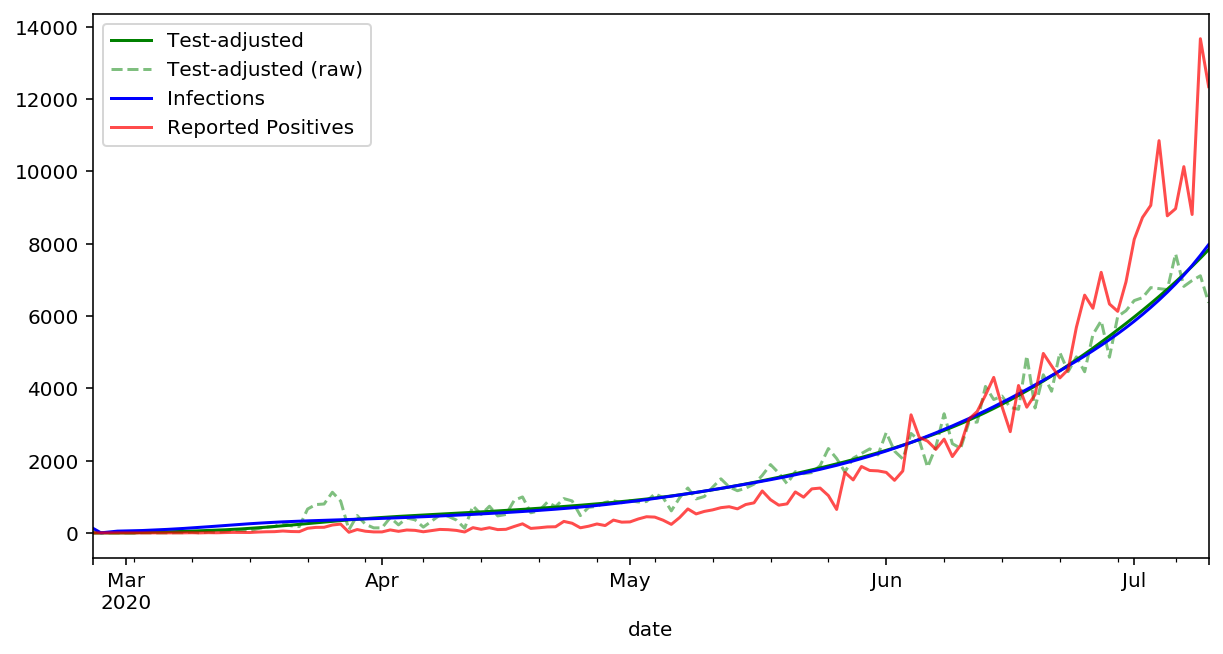

In [24]:
plot_results()

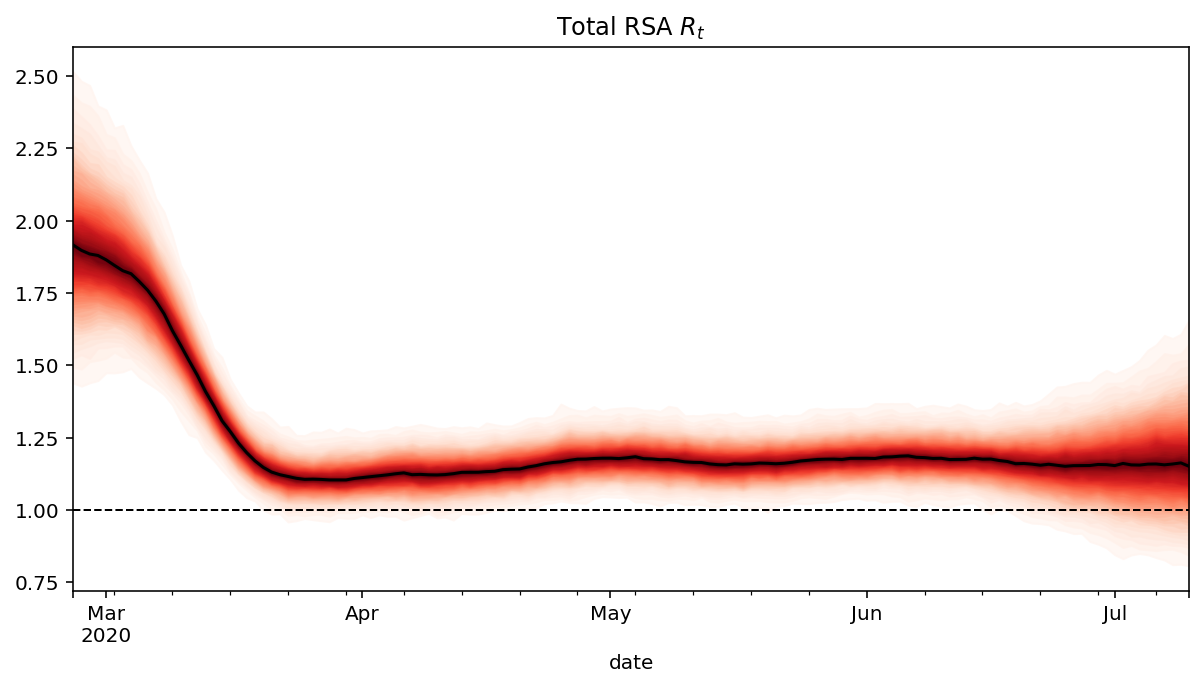

In [25]:
plot_rt()

In [26]:
export_results = result[['median','upper_80','lower_80']]
export_results = export_results.rename(columns={'median':'Median','upper_80':'High_80','lower_80':'Low_80'})
export_results.tail()

,Median,High_80,Low_80
date,,,
2020-07-06,1.158932,1.376181,0.958632
2020-07-07,1.155983,1.363967,0.922124
2020-07-08,1.158892,1.395845,0.949539
2020-07-09,1.162708,1.415658,0.957226
2020-07-10,1.150725,1.399049,0.933770


In [29]:
if remote_run:
    # Used by GitHub Action, TODO complete the action!
    # The path needs to be linked directly, TODO find out why relative path does not work
    # Action instance path /home/runner/work/covid19za/covid19za
    export_results.to_csv('data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')

else:
    export_results.to_csv('../../data/calc/calculated_rt_sa_mcmc.csv', float_format='%.3f')